In [53]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import U3Gate, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA, L_BFGS_B
from pickle import load
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install --upgrade qiskit==1.3.1 qiskit-machine-learning==0.8.2 pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=3e804963948f8ab2a44cf496715eef86e114c0a550c364981f8156641484cb2f
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


0


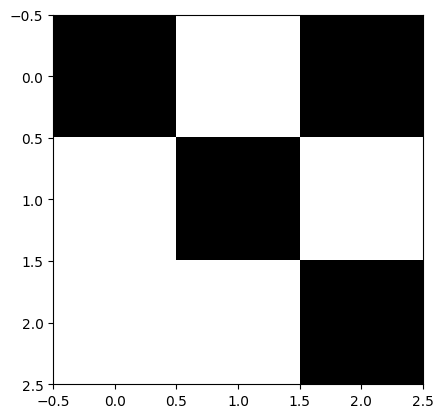

In [4]:
with open('/content/drive/MyDrive/dataset.obj',"rb") as f:
    dataset_loaded = load(f)
plt.imshow(dataset_loaded[0][0],cmap="gray")
print(dataset_loaded[0][1])

In [94]:
data = np.array([x[0].flatten() for x in dataset_loaded])
labels = np.array([x[1] for x in dataset_loaded])
if data.dtype == bool:
    data = data.astype(np.float32)
data = (data - np.min(data)) / (np.max(data) - np.min(data))
print(len(data))

104


In [95]:
for i in range(len(data)):
  if labels[i] == 0:
    labels[i] = -1
print(labels)

[-1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1
  1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1 -1
 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1  1 -1 -1 -1
  1 -1  1  1 -1  1 -1  1]


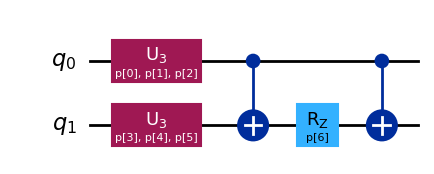

In [96]:
# Define convolutional layer
def conv_layer(qubits, weight_params, idx):
    qc = QuantumCircuit(len(qubits), name="Convolution")

    for i, q in enumerate(qubits):
        theta, phi, lam = weight_params[idx], weight_params[idx + 1], weight_params[idx+2]
        idx += 3
        qc.append(U3Gate(theta, phi, lam), [q])
    for i in range(len(qubits) - 1):
        qc.cx(i, i+1)
        qc.rz(weight_params[idx], i+1)
        qc.cx(i, i+1)
    return qc


# qubits = list(range(2))
qubits = [0,1]
params = ParameterVector("p", 7)  # 4*3 (for U3) + 1 (for ZZ)
conv = conv_layer(qubits, params, 0)
conv.draw("mpl")

In [14]:
!pip install pylatexenc

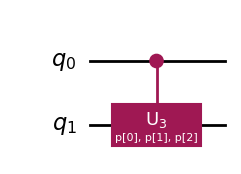

In [97]:
# Define pooling layer
def pooling_layer(ctrl, tgt, params):
    qc = QuantumCircuit(2, name="Pooling")
    u3_gate = U3Gate(*params)
    cu3 = u3_gate.control(1)
    qc.append(cu3, [0, 1])
    return qc

pool_params = ParameterVector("p", 3)
pool_circ = pooling_layer(0, 1, pool_params)
pool_circ.draw("mpl")

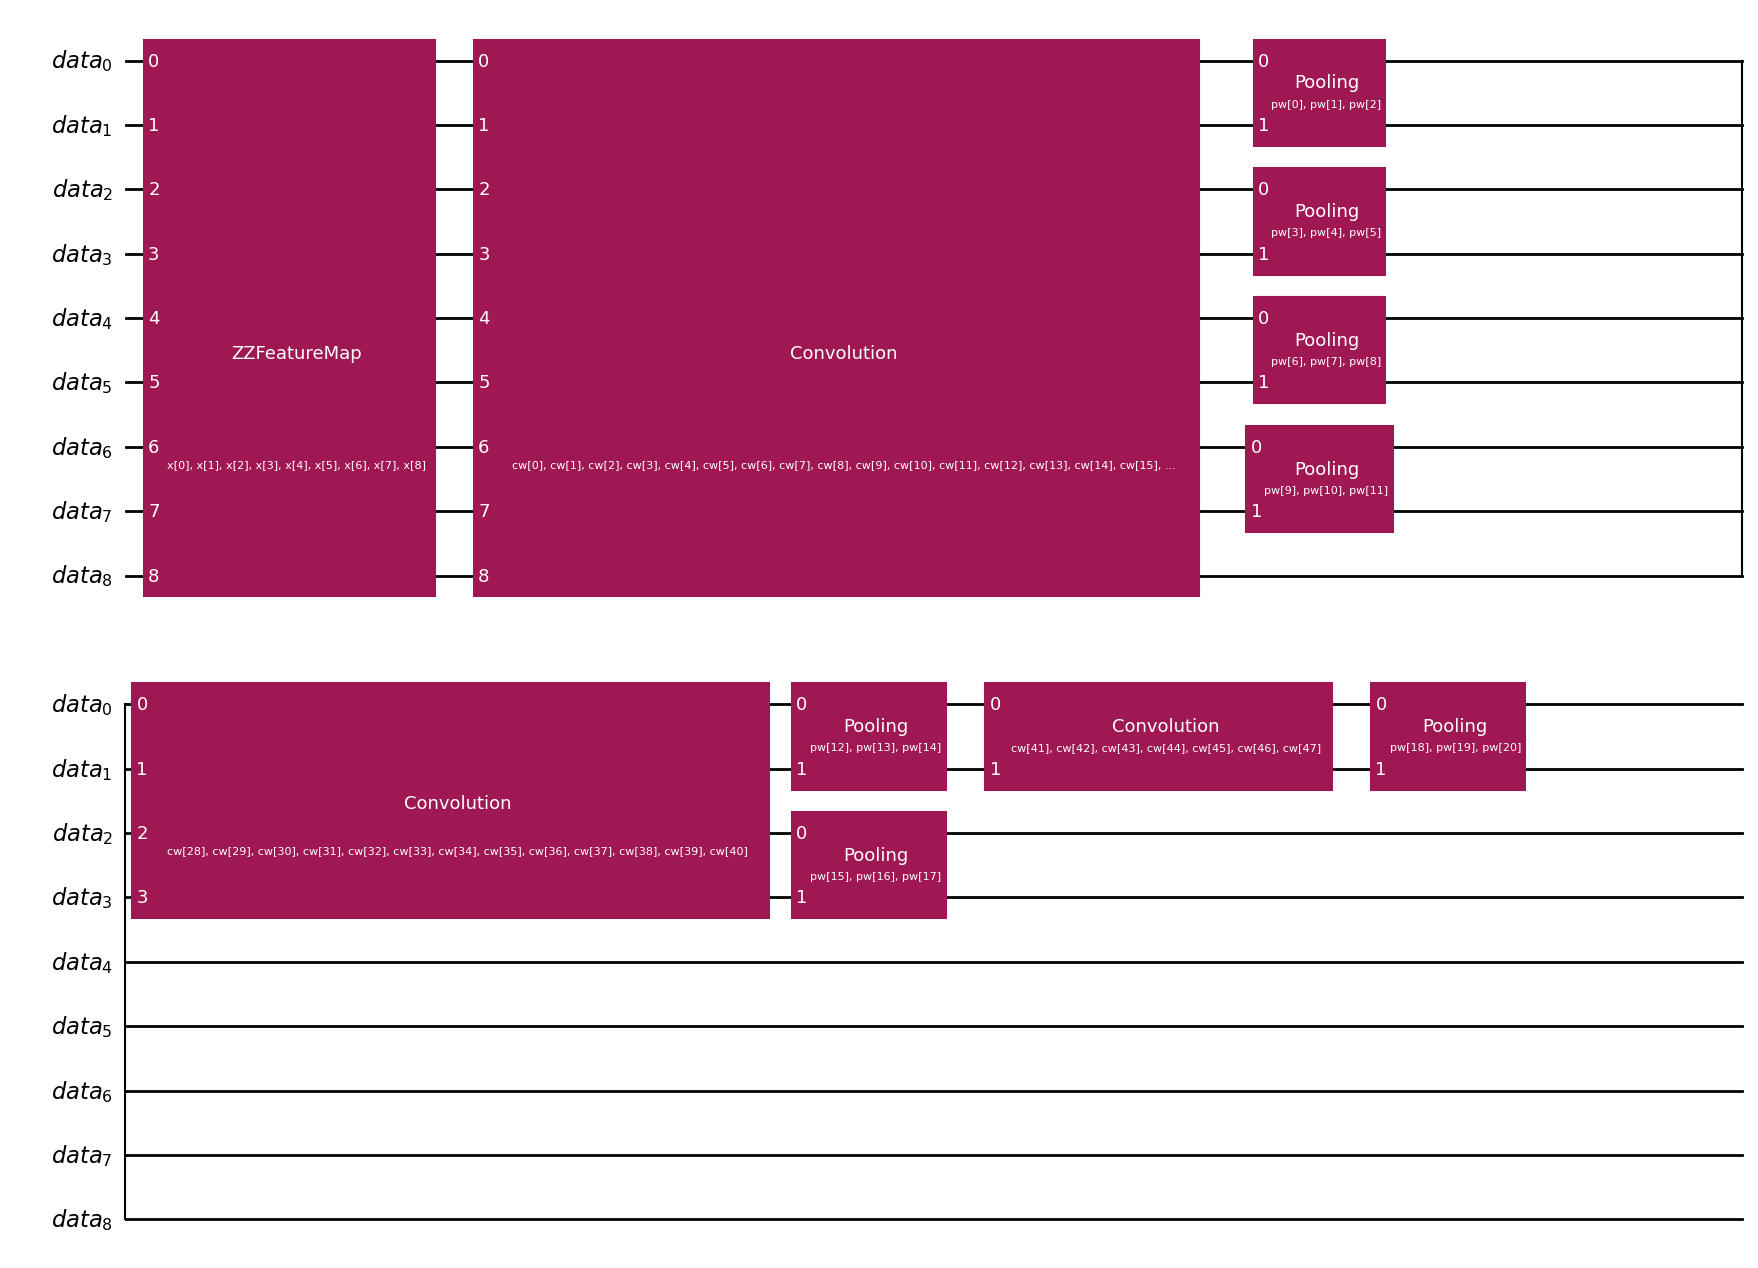

In [98]:
# Build QCNN circuit
def build_qcnn():
    data = QuantumRegister(9, 'data')
    qc = QuantumCircuit(data)

    # ZZFeatureMap with parameters
    feature_map = ZZFeatureMap(feature_dimension=9, reps=2)
    input_params = feature_map.parameters
    qc.compose(feature_map, qubits=data[:], inplace=True)

    # Define trainable parameters
    conv_weights = ParameterVector('cw', 48)
    pool_weights = ParameterVector('pw', 21)  # 7 pooling layers, 3 params each = 21

    # Layer 1 - Convolution (9 qubits)
    conv1 = conv_layer(list(range(9)), conv_weights, 0)
    qc.append(conv1.to_instruction(), data[:])

    # Layer 2 - Pooling (9 -> 4)
    pool_pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]
    for i, (ctrl, tgt) in enumerate(pool_pairs):
        idx = i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 3 - Convolution (4 qubits)
    conv2 = conv_layer(list(range(4)), conv_weights, 28)
    qc.append(conv2.to_instruction(), data[0:4])

    # Layer 4 - Pooling (4 -> 2)
    pool2_pairs = [(0, 1), (2, 3)]
    for i, (ctrl, tgt) in enumerate(pool2_pairs):
        idx = 12 + i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 5 - Convolution (2 qubits)
    conv3 = conv_layer(list(range(2)), conv_weights, 41)
    qc.append(conv3.to_instruction(), data[0:2])

    # Layer 6 - Pooling (2 -> 1)
    pool3 = pooling_layer(0, 1, pool_weights[18:21])
    qc.append(pool3.to_instruction(), [data[0], data[1]])

    return qc, input_params,  list(conv_weights) + list(pool_weights)

qcnn_circuit, input_params, weight_params = build_qcnn()
qcnn_circuit.draw("mpl")

In [12]:
print((input_params))
print((weight_params))

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8])])
[ParameterVectorElement(cw[0]), ParameterVectorElement(cw[1]), ParameterVectorElement(cw[2]), ParameterVectorElement(cw[3]), ParameterVectorElement(cw[4]), ParameterVectorElement(cw[5]), ParameterVectorElement(cw[6]), ParameterVectorElement(cw[7]), ParameterVectorElement(cw[8]), ParameterVectorElement(cw[9]), ParameterVectorElement(cw[10]), ParameterVectorElement(cw[11]), ParameterVectorElement(cw[12]), ParameterVectorElement(cw[13]), ParameterVectorElement(cw[14]), ParameterVectorElement(cw[15]), ParameterVectorElement(cw[16]), ParameterVectorElement(cw[17]), ParameterVectorElement(cw[18]), ParameterVectorElement(cw[19]), ParameterVectorElement(cw[20]), ParameterVectorElement(cw[21]), ParameterVectorElem

In [99]:
observables = SparsePauliOp.from_list([
    ("ZZIIIIIII", 1),   # horizontal (top row start)
    ("IZZIIIIII", 1),   # horizontal (middle row start)
    ("IIIZZIIII", 1),   # horizontal (bottom row start)
    ("ZIZIIIIII", 1),   # vertical (1st col)
    ("IZIZIIIII", 1),   # vertical (2nd col)
    ("IIZIZIIII", 1),   # vertical (3rd col)
    ("ZIIIZIIII", 1),   # diagonal (\)
    ("IIZIZIZII", 1)    # anti-diagonal (/)
])
estimator = StatevectorEstimator()

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observable,
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),
    initial_point=initial_point,
    loss="cross_entropy",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")


Loss: 2.5333
Loss: 2.5166
Loss: 2.5373
Loss: 2.4970
Loss: 2.2735
Loss: 2.5157
Loss: 2.5597
Loss: 2.5302
Loss: 2.0526
Loss: 2.7940
Loss: 2.3647
Loss: 2.5333
Loss: 2.2893
Loss: -2.9407
Loss: -3.0565
Loss: 5.6915
Loss: -2.0066
Loss: -0.8518
Loss: 0.1556
Loss: -6.1448
Loss: -6.8055
Loss: 0.1792
Loss: -7.0460
Loss: -6.4340
Loss: -5.2312
Loss: -8.0781
Loss: -8.1863
Loss: -6.2384
Loss: -7.5345
Loss: -8.5831
Loss: -7.8030
Loss: -8.3396
Loss: -8.5743
Loss: -8.0301
Loss: -8.0693
Loss: -8.3247
Loss: -8.0673
Loss: -8.2760
Loss: -8.3442
Loss: -8.0494
Loss: -7.2597
Loss: -7.7690
Loss: -7.8146
Loss: -7.8420
Loss: -8.3404
Loss: -8.3525
Loss: -8.0201
Loss: -7.8092
Loss: -8.0681
Loss: -8.6391
Loss: -8.2896
Loss: -8.0379
Loss: -8.0472
Loss: -8.0664
Loss: -8.5866
Loss: -8.3314
Loss: -8.0707
Loss: -7.7730
Loss: -7.8722
Loss: -7.7646
Loss: -6.7804
Loss: -8.3078
Loss: -8.3168
Loss: -7.8039
Loss: -7.7871
Loss: -8.0721
Loss: -8.3162
Loss: -8.5546
Loss: -8.2553
Loss: -8.6201
Loss: -8.5405
Loss: -8.5370
Loss: -7

In [101]:
predictions = classifier.predict(data)
print(predictions)

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]


In [103]:
cr = 0
for i in range(104):  # Show first 10 samples
    # print(f"Predicted: {predictions[i]}, Actual: {labels[i]}")
    if(predictions[i] == labels[i]):
      cr += 1
print(cr)

79
